<a href="https://colab.research.google.com/github/SantoshRokaya/Transfer-Learning-for-Medical-Image-Classification/blob/main/Deep_Minds_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Medical Image Classification
Instructed  by Haotian Liu (haotian.liu@oulu.fi)

Motivation: In medical imaging, obtaining large, labeled datasets is often challenging due to privacy concerns, high annotation costs, and limited availability of expert knowledge. To effectively learn and boost performance on these smaller datasets, we leverage transfer learning techniques, which consist of models that are trained on huge amounts of data.

Goal: Improve the performance of diabetic retinopathy detection using transfer learning by fine-tuning models and understanding the classification results with visualizations and explainable AI.

Requirements:

     1. Complete the project and submit the code. For the code, you can get help from github. (45 points)
     
          The DeepDRiD dataset, template code, and online evaluation are available on Kaggle: https://www.kaggle.com/t/41e0944a6839469fadd529fabab45e06. You should only use this dataset for final project purposes.
          You are required to complete a few tasks as follows. Please check the instruction document below for more information.

          a) Fine-tune a pre-trained model using the DeepDRiD dataset. (5 points)

          b) Two-stage training with additional datasets. (5 points)

          c) Incorporate attention mechanisms in the model. (10 points)

          d) Compare the performance of different models and strategies. (20 points)

          e) Creating Visualizations and Explainable AI. (5 points)

     2. Submit a report for this project. (15 points)

          The report should include a description of the methods used in the project, experimental results, and discussions.

# Task A: Fine-tune a pre-trained model using the DeepDRiD dataset. (5 points)

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload your kaggle.json file

# Move the API key to the correct location
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"

# Create the Kaggle directory and copy the API key there
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json  # Secure the key file

# Download DeepDRiD dataset
!kaggle competitions download -c 521153S-3005-final-project

# Unzip the downloaded dataset
!unzip 521153S-3005-final-project.zip

# List the contents of the current directory to verify
import os
os.listdir()



Saving kaggle.json to kaggle.json
100% 396M/396M [00:23<00:00, 18.4MB/s]
100% 396M/396M [00:23<00:00, 17.7MB/s]
Archive:  521153S-3005-final-project.zip
  inflating: 521153S-3005-final-project/DeepDRiD/sample_submission.csv  
  inflating: 521153S-3005-final-project/DeepDRiD/test.csv  
  inflating: 521153S-3005-final-project/DeepDRiD/test/347/347_l1.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/347/347_l2.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/347/347_r1.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/347/347_r2.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/353/353_l1.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/353/353_l2.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/353/353_r1.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/353/353_r2.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/354/354_l1.jpg  
  inflating: 521153S-3005-final-project/DeepDRiD/test/354/354_l2.jpg  
  in

['.config',
 'kaggle.json',
 'release',
 '521153S-3005-final-project',
 '521153S-3005-final-project.zip',
 'sample_data']

In [3]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm

# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 20


class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]


class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img


class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))


class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img


transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model


def evaluate_model(model, test_loader, device, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall


class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=False)  # Set pretrained to False
        # Load your custom pretrained model from file
        pretrained_model_path = '/content/521153S-3005-final-project/pretrained_DR_resize/pretrained/resnet18.pth'
        self.backbone.load_state_dict(torch.load(pretrained_model_path, map_location='cpu'))

        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x


class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet18(pretrained=False)  # Set pretrained to False
        # Load your custom pretrained model from file
        pretrained_model_path = '/content/521153S-3005-final-project/pretrained_DR_resize/pretrained/resnet18.pth'
        backbone.load_state_dict(torch.load(pretrained_model_path, map_location='cpu'))
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


if __name__ == '__main__':
    # Choose between 'single image' and 'dual images' pipeline
    # This will affect the model definition, dataset pipeline, training and evaluation

    # mode = 'single'  # forward single image to the model each time
    mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/train.csv', '521153S-3005-final-project/DeepDRiD/train/', transform_train, mode)
    val_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/val.csv', '521153S-3005-final-project/DeepDRiD/val/', transform_test, mode)
    test_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/test.csv', '521153S-3005-final-project/DeepDRiD/test/', transform_test, mode, test=True)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device is possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move class weights to the device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and evaluate the model with the training and validation set
    model = train_model(
        model, train_loader, val_loader, device, criterion, optimizer,
        lr_scheduler=lr_scheduler, num_epochs=num_epochs,
        checkpoint_path='./model_1.pth'
    )

    # Load the pretrained checkpoint
    state_dict = torch.load('./model_1.pth', map_location='cpu', weights_only=True)
    model.load_state_dict(state_dict, strict=True)

    # Make predictions on testing set and save the prediction results
    evaluate_model(model, test_loader, device, test_only=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyDualModel(
  (backbone1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Task B: Two-stage training with additional datasets. (5 points)

The data set used here for two-stage training is [APTOS 2019](https://www.kaggle.com/datasets/mariaherrerot/aptos2019).


In [4]:
#Download and unzip the APTOS 2019 dataset
!kaggle datasets download -d mariaherrerot/aptos2019
!unzip aptos2019.zip -d /content/aptos_data

Dataset URL: https://www.kaggle.com/datasets/mariaherrerot/aptos2019
License(s): unknown
100% 8.01G/8.01G [06:21<00:00, 20.2MB/s]
100% 8.01G/8.01G [06:21<00:00, 22.6MB/s]
Archive:  aptos2019.zip
  inflating: /content/aptos_data/test.csv  
  inflating: /content/aptos_data/test_images/test_images/e4dcca36ceb4.png  
  inflating: /content/aptos_data/test_images/test_images/e4e343eaae2a.png  
  inflating: /content/aptos_data/test_images/test_images/e4f12411fd85.png  
  inflating: /content/aptos_data/test_images/test_images/e50b0174690d.png  
  inflating: /content/aptos_data/test_images/test_images/e5197d77ec68.png  
  inflating: /content/aptos_data/test_images/test_images/e529c5757d64.png  
  inflating: /content/aptos_data/test_images/test_images/e52ed5c29c5e.png  
  inflating: /content/aptos_data/test_images/test_images/e540d2e35d15.png  
  inflating: /content/aptos_data/test_images/test_images/e55188915f9d.png  
  inflating: /content/aptos_data/test_images/test_images/e580676516b0.png  
 

In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import precision_score, recall_score, accuracy_score, cohen_kappa_score
from tqdm import tqdm
from collections import defaultdict
from PIL import Image

# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, label_file, transform=None, oversample=False):
        """
        Initialize the dataset with image paths and corresponding labels.
        Optionally, oversample at the patient level.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.oversample = oversample
        self.image_paths = []
        self.labels = []
        self.patient_data = defaultdict(list)

        # Load labels from CSV file
        self.label_df = pd.read_csv(label_file)

        # Build image paths and labels
        for _, row in self.label_df.iterrows():
            image_filename = row['id_code'] + '.png'
            label = row['diagnosis']
            image_path = os.path.join(root_dir, image_filename)
            self.image_paths.append(image_path)
            self.labels.append(label)

            patient_id = row['id_code']
            self.patient_data[patient_id].append(image_path)

        # Oversample images at the patient level
        if self.oversample:
            self.image_paths = []
            self.labels = []
            for patient_id, images in self.patient_data.items():
                self.image_paths.extend(images)
                self.labels.extend([self.label_df[self.label_df['id_code'] == patient_id]['diagnosis'].values[0]] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transformation for training and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the pretrained ResNet18 model
pretrained_model_path = '/content/521153S-3005-final-project/pretrained_DR_resize/pretrained/resnet18.pth'

# Initialize ResNet18 and load pretrained weights
resnet = models.resnet18(pretrained=False)  # Initialize without pretrained weights
resnet.load_state_dict(torch.load(pretrained_model_path))  # Load your custom pretrained weights

# Remove fully connected (fc) layer
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

# Custom Model (without attention layers)
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.resnet = resnet
        self.fc1 = nn.Linear(512, 256)  # 512 is the output from ResNet18
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 5)  # Output layer (5 classes for classification)

    def forward(self, x):
        x = self.resnet(x)  # Extract features using ResNet
        x = x.view(x.size(0), -1)  # Flatten after ResNet
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)  # Final output
        return x

# File paths for the training, validation, and test CSV files (APTOS dataset)
train_csv = '/content/aptos_data/train_1.csv'
val_csv = '/content/aptos_data/valid.csv'
test_csv = '/content/aptos_data/test.csv'

# Datasets for APTOS dataset
train_dataset = CustomImageDataset(root_dir='/content/aptos_data/train_images/train_images',
                                   label_file=train_csv,
                                   transform=transform_train, oversample=True)

val_dataset = CustomImageDataset(root_dir='/content/aptos_data/val_images/val_images',
                                 label_file=val_csv,
                                 transform=transform_test)

test_dataset = CustomImageDataset(root_dir='/content/aptos_data/test_images/test_images',
                                  label_file=test_csv,
                                  transform=transform_test)

# DataLoader for training, validation, and testing (APTOS)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = CustomModel().cuda()  # Model without attention layers
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters for Stage 1
num_epochs = 10
best_val_kappa = 0.0  # Best validation Kappa score
early_stop_counter = 0
patience = 5  # Number of epochs to wait for improvement before early stopping

# Stage 1: Fine-tune the model on APTOS dataset (train from scratch)
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []

    # Training loop
    with tqdm(train_loader, unit='batch', desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100) as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy and collect metrics
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update progress bar
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
            running_loss += loss.item()

    # Calculate Training Metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds
    train_kappa = cohen_kappa_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='macro')

    print(f"[Train] Kappa: {train_kappa:.4f} Accuracy: {epoch_accuracy:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f} Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        with tqdm(val_loader, unit='batch', desc="Evaluating", ncols=100) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU

                outputs = model(inputs)  # Forward pass
                _, preds = torch.max(outputs, 1)  # Get predicted class

                correct_preds += torch.sum(preds == labels).item()
                total_preds += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_accuracy = correct_preds / total_preds
        val_kappa = cohen_kappa_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro')

        print(f"[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}")

        # Save the best model based on validation Kappa score
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            torch.save(model.state_dict(), '/content/fine_tuned_model_stage1.pth')
            print(f"Model saved with Best Kappa: {best_val_kappa:.4f}, Epoch {epoch+1}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Stage 2: Fine-tune the model on the DeepDRiD dataset (freeze all layers except the final one)

# Assuming the DeepDRiD dataset paths and CSV are specified correctly
train_deepdrid_csv = '/content/deepdrid_data/train.csv'
val_deepdrid_csv = '/content/deepdrid_data/val.csv'
test_deepdrid_csv = '/content/deepdrid_data/test.csv'

# Datasets for DeepDRiD dataset
train_deepdrid_dataset = CustomImageDataset(root_dir='/content/deepdrid_data/train_images',
                                            label_file=train_deepdrid_csv,
                                            transform=transform_train)

val_deepdrid_dataset = CustomImageDataset(root_dir='/content/deepdrid_data/val_images',
                                          label_file=val_deepdrid_csv,
                                          transform=transform_test)

test_deepdrid_dataset = CustomImageDataset(root_dir='/content/deepdrid_data/test_images',
                                           label_file=test_deepdrid_csv,
                                           transform=transform_test)

# DataLoader for training, validation, and testing (DeepDRiD)
train_deepdrid_loader = DataLoader(train_deepdrid_dataset, batch_size=32, shuffle=True)
val_deepdrid_loader = DataLoader(val_deepdrid_dataset, batch_size=32, shuffle=False)
test_deepdrid_loader = DataLoader(test_deepdrid_dataset, batch_size=32, shuffle=False)

# Freeze all layers except the final one
for param in model.resnet.parameters():
    param.requires_grad = False  # Freeze all layers except the final one

# Use the same optimizer as in Stage 1, but only for the final layer
optimizer = optim.Adam(model.fc3.parameters(), lr=0.001)

# Training loop for Stage 2
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []

    # Training loop
    with tqdm(train_deepdrid_loader, unit='batch', desc=f"Epoch {epoch+1}/{num_epochs} (Stage 2)", ncols=100) as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy and collect metrics
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update progress bar
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
            running_loss += loss.item()

    # Calculate Training Metrics
    epoch_loss = running_loss / len(train_deepdrid_loader)
    epoch_accuracy = correct_preds / total_preds
    train_kappa = cohen_kappa_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='macro')

    print(f"[Train] Kappa: {train_kappa:.4f} Accuracy: {epoch_accuracy:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f} Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        with tqdm(val_deepdrid_loader, unit='batch', desc="Evaluating (Stage 2)", ncols=100) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU

                outputs = model(inputs)  # Forward pass
                _, preds = torch.max(outputs, 1)  # Get predicted class

                correct_preds += torch.sum(preds == labels).item()
                total_preds += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_accuracy = correct_preds / total_preds
        val_kappa = cohen_kappa_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro')

        print(f"[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}")

# Save the fine-tuned model for Stage 2
torch.save(model.state_dict(), '/content/fine_tuned_model_stage2.pth')
print("Model saved after Stage 2 fine-tuning.")


Epoch 1/10: 100%|██████████████████████████| 92/92 [05:49<00:00,  3.80s/batch, loss=0.819, lr=0.001]


[Train] Kappa: 0.4854 Accuracy: 0.6881 Precision: 0.3013 Recall: 0.3540 Loss: 0.9197


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.90s/batch]


[Val] Kappa: 0.4176 Accuracy: 0.6503 Precision: 0.3506 Recall: 0.3376
Model saved with Best Kappa: 0.4176, Epoch 1


Epoch 2/10: 100%|███████████████████████████| 92/92 [05:48<00:00,  3.79s/batch, loss=1.01, lr=0.001]


[Train] Kappa: 0.5723 Accuracy: 0.7365 Precision: 0.3653 Recall: 0.3892 Loss: 0.7433


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.90s/batch]


[Val] Kappa: 0.5975 Accuracy: 0.7459 Precision: 0.4171 Recall: 0.4096
Model saved with Best Kappa: 0.5975, Epoch 2


Epoch 3/10: 100%|██████████████████████████| 92/92 [05:46<00:00,  3.77s/batch, loss=0.751, lr=0.001]


[Train] Kappa: 0.6026 Accuracy: 0.7526 Precision: 0.3955 Recall: 0.4182 Loss: 0.6859


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.86s/batch]


[Val] Kappa: 0.6095 Accuracy: 0.7514 Precision: 0.4212 Recall: 0.4265
Model saved with Best Kappa: 0.6095, Epoch 3


Epoch 4/10: 100%|██████████████████████████| 92/92 [05:48<00:00,  3.79s/batch, loss=0.686, lr=0.001]


[Train] Kappa: 0.6132 Accuracy: 0.7570 Precision: 0.5678 Recall: 0.4391 Loss: 0.6514


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.88s/batch]


[Val] Kappa: 0.5799 Accuracy: 0.7350 Precision: 0.3346 Recall: 0.3919


Epoch 5/10: 100%|███████████████████████████| 92/92 [05:49<00:00,  3.80s/batch, loss=0.81, lr=0.001]


[Train] Kappa: 0.6333 Accuracy: 0.7683 Precision: 0.5121 Recall: 0.4636 Loss: 0.6245


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.93s/batch]


[Val] Kappa: 0.6432 Accuracy: 0.7732 Precision: 0.4563 Recall: 0.4573
Model saved with Best Kappa: 0.6432, Epoch 5


Epoch 6/10: 100%|██████████████████████████| 92/92 [05:49<00:00,  3.79s/batch, loss=0.526, lr=0.001]


[Train] Kappa: 0.6262 Accuracy: 0.7638 Precision: 0.5033 Recall: 0.4628 Loss: 0.6101


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.91s/batch]


[Val] Kappa: 0.6631 Accuracy: 0.7814 Precision: 0.5062 Recall: 0.5000
Model saved with Best Kappa: 0.6631, Epoch 6


Epoch 7/10: 100%|██████████████████████████| 92/92 [05:48<00:00,  3.79s/batch, loss=0.597, lr=0.001]


[Train] Kappa: 0.6441 Accuracy: 0.7730 Precision: 0.5000 Recall: 0.4879 Loss: 0.5715


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.94s/batch]


[Val] Kappa: 0.6403 Accuracy: 0.7678 Precision: 0.4271 Recall: 0.4803


Epoch 8/10: 100%|██████████████████████████| 92/92 [05:49<00:00,  3.80s/batch, loss=0.621, lr=0.001]


[Train] Kappa: 0.6465 Accuracy: 0.7751 Precision: 0.5250 Recall: 0.4862 Loss: 0.5710


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.93s/batch]


[Val] Kappa: 0.6709 Accuracy: 0.7814 Precision: 0.5310 Recall: 0.5752
Model saved with Best Kappa: 0.6709, Epoch 8


Epoch 9/10: 100%|██████████████████████████| 92/92 [05:49<00:00,  3.79s/batch, loss=0.233, lr=0.001]


[Train] Kappa: 0.6624 Accuracy: 0.7826 Precision: 0.5468 Recall: 0.5258 Loss: 0.5431


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.93s/batch]


[Val] Kappa: 0.6667 Accuracy: 0.7814 Precision: 0.5056 Recall: 0.5186


Epoch 10/10: 100%|█████████████████████████| 92/92 [05:48<00:00,  3.79s/batch, loss=0.492, lr=0.001]


[Train] Kappa: 0.6618 Accuracy: 0.7823 Precision: 0.5713 Recall: 0.5263 Loss: 0.5313


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.92s/batch]

[Val] Kappa: 0.6726 Accuracy: 0.7869 Precision: 0.6137 Recall: 0.5314
Model saved with Best Kappa: 0.6726, Epoch 10


# Step C Incorporate attention mechanisms in the model. (10 points)

In [6]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import precision_score, recall_score, accuracy_score, cohen_kappa_score
from tqdm import tqdm
from collections import defaultdict
from PIL import Image

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, label_file, transform=None, oversample=False):
        self.root_dir = root_dir
        self.transform = transform
        self.oversample = oversample
        self.image_paths = []
        self.labels = []
        self.patient_data = defaultdict(list)

        # Load the labels from the CSV file
        self.label_df = pd.read_csv(label_file)

        for _, row in self.label_df.iterrows():
            image_filename = row['id_code'] + '.png'
            label = row['diagnosis']

            image_path = os.path.join(root_dir, image_filename)
            self.image_paths.append(image_path)
            self.labels.append(label)
            patient_id = row['id_code']
            self.patient_data[patient_id].append(image_path)

        if self.oversample:
            self.image_paths = []
            self.labels = []
            for patient_id, images in self.patient_data.items():
                self.image_paths.extend(images)
                self.labels.extend([self.label_df[self.label_df['id_code'] == patient_id]['diagnosis'].values[0]] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load pre-trained ResNet model without fully connected layers
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
modules = list(resnet.children())[:-1]  # Remove the fully connected (fc) layer
resnet = nn.Sequential(*modules)

# Channel Attention (Squeeze-and-Excitation) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        # Squeeze: Global Average Pooling
        x_se = x.mean(dim=[2, 3], keepdim=True)
        x_se = x_se.view(batch_size, channels)
        # Excitation: Fully connected layers
        x_se = self.fc1(x_se)
        x_se = self.relu(x_se)
        x_se = self.fc2(x_se)
        x_se = self.sigmoid(x_se).view(batch_size, channels, 1, 1)
        # Recalibrate: Apply attention to each channel
        return x * x_se

# Spatial Attention Layer
class SpatialAttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttentionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply convolution to generate spatial attention map
        attn_map = self.conv(x)
        attn_map = self.sigmoid(attn_map)  # Generate attention map (1 channel)
        # Apply the spatial attention to the input feature map
        return x * attn_map

# Custom Model with both Channel and Spatial Attention
class CustomModelWithAttention(nn.Module):
    def __init__(self):
        super(CustomModelWithAttention, self).__init__()
        self.resnet = resnet
        self.se_block = SEBlock(512)  # Channel attention (SE block)
        self.spatial_attention = SpatialAttentionLayer(512)  # Spatial attention
        self.fc1 = nn.Linear(512, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 5)  # Output layer (5 classes for classification)

    def forward(self, x):
        x = self.resnet(x)  # Extract features using ResNet
        # ResNet output shape: (batch_size, 512, 1, 1)

        # Apply Channel Attention
        x = self.se_block(x)
        # Apply Spatial Attention
        x = self.spatial_attention(x)

        x = x.view(x.size(0), -1)  # Flatten after attention
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)  # Final output
        return x

train_csv = '/content/aptos_data/train_1.csv'
val_csv = '/content/aptos_data/valid.csv'
test_csv = '/content/aptos_data/test.csv'

train_dataset = CustomImageDataset(root_dir='/content/aptos_data/train_images/train_images',
                                   label_file=train_csv,
                                   transform=transform_train, oversample=True)

val_dataset = CustomImageDataset(root_dir='/content/aptos_data/val_images/val_images',
                                 label_file=val_csv,
                                 transform=transform_test)

test_dataset = CustomImageDataset(root_dir='/content/aptos_data/test_images/test_images',
                                  label_file=test_csv,
                                  transform=transform_test)

# DataLoader for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = CustomModelWithAttention().cuda()  # Model with attention
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
best_val_kappa = 0.0  # Best validation Kappa score
early_stop_counter = 0
patience = 5  # Number of epochs to wait for improvement before early stopping

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []

    # Training Loop
    with tqdm(train_loader, unit='batch', desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100) as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy and collect metrics
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update progress bar
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

            running_loss += loss.item()

    # Calculate Training Metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds
    train_kappa = cohen_kappa_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='macro')

    print(f"[Train] Kappa: {train_kappa:.4f} Accuracy: {epoch_accuracy:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f} Loss: {epoch_loss:.4f}")

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        with tqdm(val_loader, unit='batch', desc="Evaluating", ncols=100) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU

                outputs = model(inputs)  # Forward pass
                _, preds = torch.max(outputs, 1)  # Get predicted class

                correct_preds += torch.sum(preds == labels).item()
                total_preds += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_accuracy = correct_preds / total_preds
        val_kappa = cohen_kappa_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro')

        print(f"[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}")

        # Save the best model based on validation Kappa score
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            torch.save(model.state_dict(), '/content/fine_tuned_model_with_attention.pth')
            print(f"Model saved with Best Kappa: {best_val_kappa:.4f}, Epoch {epoch+1}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch 1/10: 100%|██████████████████████████| 92/92 [05:51<00:00,  3.82s/batch, loss=0.958, lr=0.001]


[Train] Kappa: 0.5066 Accuracy: 0.6966 Precision: 0.4487 Recall: 0.3665 Loss: 0.8887


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.96s/batch]


[Val] Kappa: 0.5783 Accuracy: 0.7350 Precision: 0.3985 Recall: 0.3919
Model saved with Best Kappa: 0.5783, Epoch 1


Epoch 2/10: 100%|██████████████████████████| 92/92 [05:50<00:00,  3.81s/batch, loss=0.821, lr=0.001]


[Train] Kappa: 0.5925 Accuracy: 0.7464 Precision: 0.4932 Recall: 0.4139 Loss: 0.7075


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.94s/batch]


[Val] Kappa: 0.6000 Accuracy: 0.7377 Precision: 0.3934 Recall: 0.4653
Model saved with Best Kappa: 0.6000, Epoch 2


Epoch 3/10: 100%|██████████████████████████| 92/92 [05:51<00:00,  3.82s/batch, loss=0.993, lr=0.001]


[Train] Kappa: 0.5893 Accuracy: 0.7433 Precision: 0.4863 Recall: 0.4183 Loss: 0.6857


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.90s/batch]


[Val] Kappa: 0.5901 Accuracy: 0.7322 Precision: 0.3895 Recall: 0.4631


Epoch 4/10: 100%|████████████████████████████| 92/92 [05:50<00:00,  3.81s/batch, loss=2.1, lr=0.001]


[Train] Kappa: 0.6154 Accuracy: 0.7597 Precision: 0.4174 Recall: 0.4364 Loss: 0.6401


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.94s/batch]


[Val] Kappa: 0.6665 Accuracy: 0.7842 Precision: 0.4447 Recall: 0.5004
Model saved with Best Kappa: 0.6665, Epoch 4


Epoch 5/10: 100%|██████████████████████████| 92/92 [05:50<00:00,  3.81s/batch, loss=0.592, lr=0.001]


[Train] Kappa: 0.6298 Accuracy: 0.7672 Precision: 0.5063 Recall: 0.4546 Loss: 0.6296


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.92s/batch]


[Val] Kappa: 0.6162 Accuracy: 0.7541 Precision: 0.4437 Recall: 0.4468


Epoch 6/10: 100%|███████████████████████████| 92/92 [05:49<00:00,  3.80s/batch, loss=1.06, lr=0.001]


[Train] Kappa: 0.6398 Accuracy: 0.7710 Precision: 0.5985 Recall: 0.4760 Loss: 0.5795


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.90s/batch]


[Val] Kappa: 0.6544 Accuracy: 0.7760 Precision: 0.4380 Recall: 0.4930


Epoch 7/10: 100%|██████████████████████████| 92/92 [05:50<00:00,  3.81s/batch, loss=0.544, lr=0.001]


[Train] Kappa: 0.6565 Accuracy: 0.7805 Precision: 0.5673 Recall: 0.5020 Loss: 0.5562


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.94s/batch]


[Val] Kappa: 0.6358 Accuracy: 0.7541 Precision: 0.5181 Recall: 0.5647


Epoch 8/10: 100%|██████████████████████████| 92/92 [05:51<00:00,  3.83s/batch, loss=0.428, lr=0.001]


[Train] Kappa: 0.6744 Accuracy: 0.7891 Precision: 0.5808 Recall: 0.5416 Loss: 0.5259


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.91s/batch]


[Val] Kappa: 0.6434 Accuracy: 0.7705 Precision: 0.5109 Recall: 0.4846


Epoch 9/10: 100%|██████████████████████████| 92/92 [05:51<00:00,  3.82s/batch, loss=0.713, lr=0.001]


[Train] Kappa: 0.6735 Accuracy: 0.7904 Precision: 0.6146 Recall: 0.5255 Loss: 0.5198


Evaluating: 100%|████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.92s/batch]

[Val] Kappa: 0.6226 Accuracy: 0.7432 Precision: 0.5315 Recall: 0.5534
Early stopping triggered after 9 epochs.


# Step D Compare the performance of different models and strategies. (20 points)

In [8]:
import os
import numpy as np
import torch
import cv2
import torch.nn as nn
from torchvision import models, transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from PIL import Image, ImageFilter
from collections import defaultdict
from tqdm import tqdm  # Added for progress bar
import pandas as pd

# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, label_file, transform=None, oversample=False):
        self.root_dir = root_dir
        self.label_file = label_file
        self.transform = transform
        self.oversample = oversample
        self.image_paths = []
        self.labels = []
        self.patient_data = defaultdict(list)

        print(f"Loading labels from {label_file}...")
        self.label_df = pd.read_csv(label_file)
        print(f"Label file loaded. {len(self.label_df)} rows found.")

        for _, row in self.label_df.iterrows():
            image_filename = row['id_code'] + '.png'
            label = row['diagnosis']
            image_path = os.path.join(root_dir, image_filename)

            if os.path.exists(image_path):  # Check if the image file exists
                self.image_paths.append(image_path)
                self.labels.append(label)
                patient_id = row['id_code']
                self.patient_data[patient_id].append(image_path)
            else:
                print(f"Warning: File {image_path} not found.")

        if self.oversample:
            print("Oversampling enabled. Rebuilding image paths...")
            self.image_paths = []
            self.labels = []
            for patient_id, images in self.patient_data.items():
                self.image_paths.extend(images)
                self.labels.extend([self.label_df[self.label_df['id_code'] == patient_id]['diagnosis'].values[0]] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Image Preprocessing Functions
def apply_clahe(image):
    img = np.array(image)

    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(gray_img)

    # Convert back to RGB
    enhanced_img_rgb = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)

    return Image.fromarray(enhanced_img_rgb)


def apply_gaussian_blur(image):
    img = np.array(image)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return Image.fromarray(img)


def apply_sharpening(image):
    img = image.filter(ImageFilter.SHARPEN)
    return img


def apply_circle_crop(image):
    img = np.array(image)
    mask = np.zeros_like(img)
    rows, cols = img.shape[:2]
    center = (cols // 2, rows // 2)
    radius = min(cols, rows) // 2
    cv2.circle(mask, center, radius, (255, 255, 255), -1)
    img = cv2.bitwise_and(img, mask)
    return Image.fromarray(img)


def preprocess_data(dataloader, preprocess_type='clahe'):
    transform_list = [transforms.Resize((224, 224))]

    if preprocess_type == 'clahe':
        transform_list.append(transforms.Lambda(lambda img: apply_clahe(img)))
    elif preprocess_type == 'blur':
        transform_list.append(transforms.Lambda(lambda img: apply_gaussian_blur(img)))
    elif preprocess_type == 'sharpen':
        transform_list.append(transforms.Lambda(lambda img: apply_sharpening(img)))
    elif preprocess_type == 'crop':
        transform_list.append(transforms.Lambda(lambda img: apply_circle_crop(img)))

    transform_list.append(transforms.ToTensor())

    transform = transforms.Compose(transform_list)

    return DataLoader(
        CustomImageDataset(
            root_dir=dataloader.dataset.root_dir,
            label_file=dataloader.dataset.label_file,
            transform=transform,
            oversample=dataloader.dataset.oversample
        ),
        batch_size=dataloader.batch_size if hasattr(dataloader, 'batch_size') else 32,
        shuffle=getattr(dataloader, 'shuffle', True)
    )


class TransferModel(nn.Module):
    def __init__(self, model_type, num_classes=5, pretrained=True):
        super(TransferModel, self).__init__()

        if model_type == 'resnet18':
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
            model.fc = nn.Linear(model.fc.in_features, num_classes)

        elif model_type == 'vgg16':
            model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

        elif model_type == 'efficientnet':
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

        else:
            raise ValueError(f"Model {model_type} not supported")

        self.model = model

    def forward(self, x):
        return self.model(x)


def max_voting_ensemble(models, dataloader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            all_labels.extend(labels.cpu().numpy())

            outputs = []
            for model in models:
                model.eval()
                outputs.append(torch.softmax(model(inputs), dim=1))  # Use softmax for probabilities

            avg_outputs = torch.stack(outputs).mean(dim=0)
            preds = torch.argmax(avg_outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


def evaluate_model(model, val_loader):
    model.eval()
    predictions, ground_truth = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(ground_truth, predictions))

    kappa = cohen_kappa_score(ground_truth, predictions)
    print(f"Cohen's Kappa Score: {kappa:.4f}")
    return kappa


# Main Code
print("Preparing datasets and dataloaders...")
train_csv = '/content/aptos_data/train_1.csv'
val_csv = '/content/aptos_data/valid.csv'
transform_train = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
transform_test = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = CustomImageDataset(
    root_dir='/content/aptos_data/train_images/train_images',
    label_file=train_csv, transform=transform_train, oversample=True
)
val_dataset = CustomImageDataset(
    root_dir='/content/aptos_data/val_images/val_images', label_file=val_csv, transform=transform_test
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Initializing models...")
model_resnet = TransferModel('resnet18').cuda()
model_vgg = TransferModel('vgg16').cuda()
model_efficientnet = TransferModel('efficientnet').cuda()

print("Setting up training loop...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(model_resnet.parameters()) + list(model_vgg.parameters()) + list(model_efficientnet.parameters()),
    lr=0.001
)

for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    model_resnet.train()
    model_vgg.train()
    model_efficientnet.train()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100, leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        outputs_resnet = model_resnet(inputs)
        outputs_vgg = model_vgg(inputs)
        outputs_efficientnet = model_efficientnet(inputs)

        loss = (criterion(outputs_resnet, labels) +
                criterion(outputs_vgg, labels) +
                criterion(outputs_efficientnet, labels))

        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

print("Evaluating models...")
for model in [model_resnet, model_vgg, model_efficientnet]:
    kappa = evaluate_model(model, val_loader)

train_loader_clahe = preprocess_data(train_loader, 'clahe')
val_loader_clahe = preprocess_data(val_loader, 'clahe')

print("Re-evaluating Max Voting Ensemble with CLAHE Preprocessing...")
max_voting_preds, ground_truth = max_voting_ensemble(
    [model_resnet, model_vgg, model_efficientnet], val_loader_clahe)

print("Max Voting Classification Report (CLAHE):")
print(classification_report(ground_truth, max_voting_preds))
kappa = cohen_kappa_score(ground_truth, max_voting_preds)
print(f"Max Voting Cohen's Kappa Score: {kappa:.4f}")


Preparing datasets and dataloaders...
Loading labels from /content/aptos_data/train_1.csv...
Label file loaded. 2930 rows found.
Oversampling enabled. Rebuilding image paths...
Loading labels from /content/aptos_data/valid.csv...
Label file loaded. 366 rows found.
Initializing models...
Setting up training loop...
Epoch 1/10


Epoch 2/10


Epoch 3/10


Epoch 4/10


Epoch 5/10


Epoch 6/10


Epoch 7/10


Epoch 8/10


Epoch 9/10


Epoch 10/10


Evaluating models...
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       172
           1       0.58      0.62      0.60        40
           2       0.69      0.83      0.75       104
           3       0.33      0.05      0.08        22
           4       0.63      0.43      0.51        28

    accuracy                           0.80       366
   macro avg       0.64      0.58      0.58       366
weighted avg       0.78      0.80      0.78       366

Cohen's Kappa Score: 0.7018
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       172
           1       0.40      0.80      0.53        40
           2       0.66      0.61      0.63       104
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        28

    accuracy                           0.72       366
   macro avg       0.39      0.48   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       172
           1       0.77      0.60      0.68        40
           2       0.72      0.80      0.75       104
           3       0.48      0.55      0.51        22
           4       0.70      0.50      0.58        28

    accuracy                           0.83       366
   macro avg       0.73      0.69      0.70       366
weighted avg       0.83      0.83      0.83       366

Cohen's Kappa Score: 0.7468
Loading labels from /content/aptos_data/train_1.csv...
Label file loaded. 2930 rows found.
Oversampling enabled. Rebuilding image paths...
Loading labels from /content/aptos_data/valid.csv...
Label file loaded. 366 rows found.
Re-evaluating Max Voting Ensemble with CLAHE Preprocessing...
Max Voting Classification Report (CLAHE):
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       172
           1       1

# Step E Creating Visualizations and Explainable AI. (5 points)

Epoch 1/10


Epoch 2/10


Epoch 3/10


Epoch 4/10


Epoch 5/10


Epoch 6/10


Epoch 7/10


Epoch 8/10


Epoch 9/10


Epoch 10/10


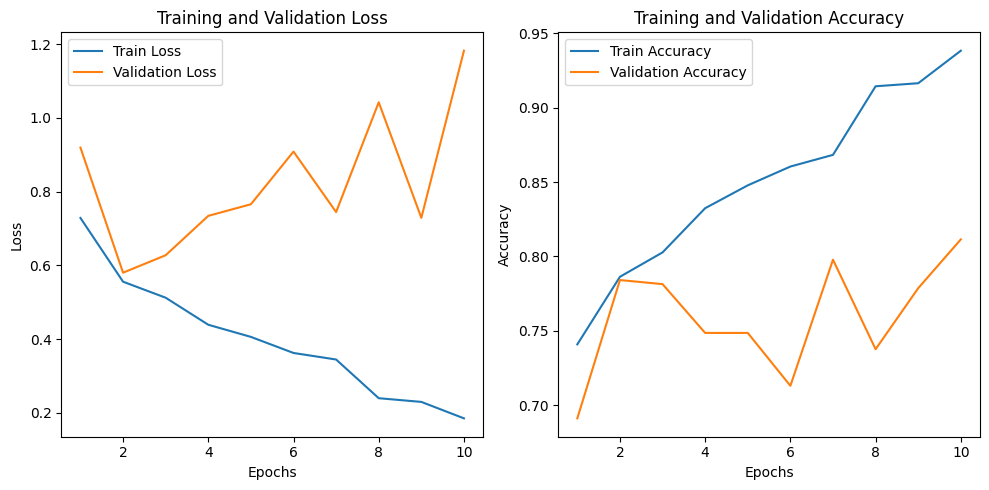

Image shape for Grad-CAM: torch.Size([1, 3, 224, 224])


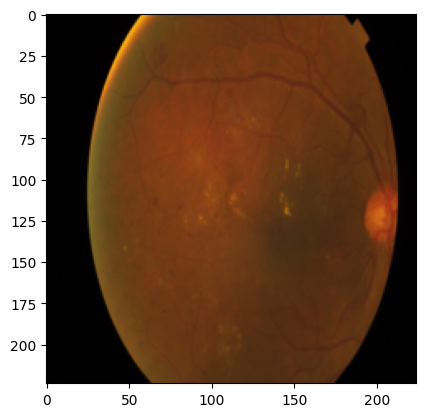

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from sklearn.metrics import accuracy_score
from PIL import Image
from tqdm import tqdm
import pandas as pd


class CustomImageDataset(Dataset):
    def __init__(self, root_dir, label_file, transform=None, oversample=False):
        self.root_dir = root_dir
        self.transform = transform
        self.oversample = oversample
        self.image_paths = []
        self.labels = []
        self.patient_data = defaultdict(list)

        self.label_df = pd.read_csv(label_file)
        for _, row in self.label_df.iterrows():
            image_filename = row['id_code'] + '.png'
            label = row['diagnosis']

            image_path = os.path.join(root_dir, image_filename)
            self.image_paths.append(image_path)
            self.labels.append(label)
            patient_id = row['id_code']
            self.patient_data[patient_id].append(image_path)

        if self.oversample:
            self.image_paths = []
            self.labels = []
            for patient_id, images in self.patient_data.items():
                self.image_paths.extend(images)
                self.labels.extend([self.label_df[self.label_df['id_code'] == patient_id]['diagnosis'].values[0]] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure image is PIL.Image
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


class TransferModel(nn.Module):
    def __init__(self, model_type, num_classes=5, pretrained=True):
        super(TransferModel, self).__init__()

        if model_type == 'resnet18':
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
            model.fc = nn.Linear(model.fc.in_features, num_classes)

        elif model_type == 'vgg16':
            model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

        elif model_type == 'efficientnet':
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

        else:
            raise ValueError(f"Model {model_type} not supported")

        self.model = model

    def forward(self, x):
        return self.model(x)


def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, epochs=10):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def main():
    train_csv = '/content/aptos_data/train_1.csv'
    val_csv = '/content/aptos_data/valid.csv'

    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = CustomImageDataset(root_dir='/content/aptos_data/train_images/train_images', label_file=train_csv, transform=transform_train)
    val_dataset = CustomImageDataset(root_dir='/content/aptos_data/val_images/val_images', label_file=val_csv, transform=transform_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = TransferModel('resnet18').cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(10):
        print(f"Epoch {epoch + 1}/10")
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc="Training Progress", leave=False):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        epoch_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation Progress", leave=False):
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Example Grad-CAM visualization
    image, label = val_dataset[0]  # Pick the first image in the validation dataset
    image = image.unsqueeze(0).cuda()  # Add batch dimension
    print(f"Image shape for Grad-CAM: {image.shape}")
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.show()


if __name__ == "__main__":
    main()
